In [1]:
import gym
import numpy as np
import random
import time 
import matplotlib.pyplot as plt
from collections import namedtuple

import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# plotting
%matplotlib inline
import time
import pylab as pl
from IPython import display
import pickle as pkl


C:\ProgramData\Anaconda3\envs\DRL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
env = gym.make("LunarLander-v2")
print(env.action_space) #[Output: ] Discrete(2)
print(env.observation_space) # [Output: ] Box(4,)


Discrete(4)
Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)


# 1 - Replay Buffer for Experience replay

Basic structure code is refered from the lab and modifed to this task for necesarry specification. 

In [3]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [4]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def save_transition(self, state, action, next_state, reward):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        state_tensor = T.from_numpy(state)
        
        if next_state is None:
            state_tensor_next = None            
        else:
            state_tensor_next = T.from_numpy(next_state)
        
        action_tensor = T.tensor([action], device=device).unsqueeze(0)

        reward = T.tensor([reward], device=device).unsqueeze(0)/10. # reward scaling

        self.memory[self.position] = Transition(state_tensor, action_tensor, state_tensor_next, reward)  # save the transition
        self.position = (self.position + 1) % self.capacity  # loop around memory

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# 2 - Q-network

In [5]:
# if gpu is to be used
device = T.device("cuda" if T.cuda.is_available() else "cpu")

class DQN(nn.Module):

    def __init__(self, input_size, size_hidden, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, size_hidden)
        self.fc2 = nn.Linear(size_hidden, size_hidden)   
        self.fc3 = nn.Linear(size_hidden, size_hidden)  
        self.fc4 = nn.Linear(size_hidden, output_size)
        
        
    def forward(self, x):
        h1 = F.relu(self.fc1(x.float()))  # self.bn1()
        h2 = F.relu(self.fc2(h1))  # self.bn2()
        h3 = F.relu(self.fc3(h2))  # self.bn3()
        output = self.fc4(h3) # .view(h3.size(0), -1)
        return output
    

In [6]:
data_list = []
rewards_histories = []
learning_rates = [0.005, 0.001, 0.0005]
memory_sizes = [10000, 100000]
i=0
for lr in learning_rates:
    for ms in memory_sizes:
        i+=1
        OBS_SIZE = 8
        HIDDEN_SIZE = 64
        ACTION_SIZE = 4

        Q_network = DQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
        Q_target = DQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
        Q_target.load_state_dict(Q_network.state_dict())
        Q_target.eval()

        TARGET_UPDATE = 20

        optimizer = optim.Adam(Q_network.parameters(), lr=lr)
        memory = ReplayMemory(ms)

        class E_Greedy_Policy():
            
            def __init__(self, epsilon, decay, min_epsilon):
                self.epsilon = epsilon
                self.epsilon_start = epsilon
                self.decay = decay
                self.epsilon_min = min_epsilon
                        
            def __call__(self, state):
                is_greedy = random.random() > self.epsilon
                if is_greedy :
                    # we select greedy action
                    with T.no_grad():
                        Q_network.eval()
                        index_action = Q_network(state).argmax().detach().cpu().numpy().item()  # state is on cpu instead of GPU!
                        Q_network.train()

                else:
                    # we sample a random action
                    index_action = env.action_space.sample() # select random action (4 possible values)
                
                return index_action
                        
            def update_epsilon(self):
                
                self.epsilon = self.epsilon*self.decay
                if self.epsilon < self.epsilon_min:
                    self.epsilon = self.epsilon_min
                
            def reset(self):
                self.epsilon = self.epsilon_start

        policy = E_Greedy_Policy(epsilon=0.5, decay=0.997, min_epsilon=0.001)
        BATCH_SIZE = 64
        GAMMA = 0.99

        def optimize_model():
            transitions = memory.sample(BATCH_SIZE)
            batch = Transition(*zip(*transitions))

            # Compute a mask of non-final states and concatenate the batch elements
            non_final_mask = T.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=T.bool)
            non_final_next_states = T.cat([s for s in batch.next_state if s is not None])
            non_final_next_states = T.reshape(non_final_next_states, (non_final_mask.sum(), -1)).float().to(device)  # Reshape to (nr. non final, 8)

            state_batch = T.cat(batch.state).float().to(device)  # .float().to(device) to move to GPU
            state_batch = T.reshape(state_batch, (BATCH_SIZE, -1))  # Reshape to (batch_size, 8)
            action_batch = T.cat(batch.action).to(device)
            reward_batch = T.cat(batch.reward).float().to(device)
            
            # Compute Q values using policy net
            Q_values = Q_network(state_batch).gather(1, action_batch)

            # Compute next Q values using Q_targets
            next_Q_values = T.zeros( BATCH_SIZE, device=device).to(device)
            next_Q_values[non_final_mask] = Q_target(non_final_next_states).max(1)[0].detach()
            next_Q_values = next_Q_values.unsqueeze(1)
            
            # Compute targets
            target_Q_values = (next_Q_values * GAMMA) + reward_batch
            
            # Compute MSE Loss
            loss = F.mse_loss(Q_values, target_Q_values)
            
            # Optimize the model
            optimizer.zero_grad()
            loss.backward()
            
            # Trick: gradient clipping
            for param in Q_network.parameters():
                param.grad.data.clamp_(-1, 1)
                
            optimizer.step()
            
            return loss

        env = gym.make("LunarLander-v2")  # create environment

        num_episodes = 1500
        policy.reset()
        rewards_history = []

        # Warmup phase!
        memory_filled = False
        print('**************** Parameters: lr={}, ms={} **************** '.format(lr, ms))
        print("Warmup phase...")
        while not memory_filled:
            
            state = env.reset()  # 8 states: coordinates of the lander (x,y), linear velocities (x,y), angle, angular velocity, 2 bools if each leg is touches ground.
            done = False
            total_reward = 0
            
            while not done:  # for each episode
                # Get action and act in the world
                state_tensor = T.from_numpy(state).float().to(device)
                action = policy(state_tensor)  # <<--- choose greedy (choose index of highest q-value predicted by network) or exploration
                next_state, reward, done, __ = env.step(action)
                total_reward += float(reward)
                
                # Observe new state
                if done:
                    next_state = None

                # Store the transition in memory
                memory.save_transition(state, action, next_state, float(reward))
                state = next_state

            memory_filled = memory.capacity == len(memory)

        print('Done with the warmup')
            
        for i_episode in range(num_episodes):
            # New dungeon at every run
            state = env.reset()
            done = False
            total_reward = 0
            
            
            while not done:  # iterate through states
                
                # Get action and act in the world
                state_tensor = T.from_numpy(state).float().to(device)  # <<--- convert state to tensor and move to GPU
                
                action = policy(state_tensor)   # choose greedy (index of q-value predictions) or exploration
                next_state, reward, done, __ = env.step(action)
                total_reward += float(reward)
                
                # Observe new state
                if done:
                    next_state = None
                memory.save_transition(state, action, next_state, float(reward))  # Store the transition in memory
                state = next_state  # Move to the next state

                # Perform one step of the optimization
                loss = optimize_model()

            policy.update_epsilon()
            rewards_history.append( float(total_reward) )

            
            # Update the target network, copying all weights and biases in DQN
            if i_episode % TARGET_UPDATE == 0:
                Q_target.load_state_dict(Q_network.state_dict())
            
            if i_episode % 10 == 0:
                avg_rewards_10 = sum(rewards_history[-10:])/10

                print('Episode {} - reward: {:.3f}, avg. reward (past 10 ep.): {:.3f}, eps: {:.3f} loss: {:.3f} '.format(
                    i_episode, total_reward, avg_rewards_10, policy.epsilon, loss))   
        
        rewards_histories.append(rewards_history)
        data = [i, lr, ms, rewards_histories]
        data_list.append(data)
        print('Complete')


**************** Parameters: lr=0.005, ms=10000 **************** 
Warmup phase...
Done with the warmup
Episode 0 - reward: -220.594, avg. reward (past 10 ep.): -22.059, eps: 0.498 loss: 1.252 
Episode 10 - reward: -123.941, avg. reward (past 10 ep.): -162.745, eps: 0.484 loss: 0.034 
Episode 20 - reward: -125.349, avg. reward (past 10 ep.): -148.922, eps: 0.469 loss: 0.386 
Episode 30 - reward: -136.602, avg. reward (past 10 ep.): -95.759, eps: 0.456 loss: 0.056 
Episode 40 - reward: -44.374, avg. reward (past 10 ep.): -92.222, eps: 0.442 loss: 0.104 
Episode 50 - reward: -57.274, avg. reward (past 10 ep.): -115.496, eps: 0.429 loss: 0.661 
Episode 60 - reward: -54.998, avg. reward (past 10 ep.): -84.451, eps: 0.416 loss: 0.393 
Episode 70 - reward: -63.462, avg. reward (past 10 ep.): -69.028, eps: 0.404 loss: 0.251 
Episode 80 - reward: -212.513, avg. reward (past 10 ep.): -125.885, eps: 0.392 loss: 0.052 
Episode 90 - reward: -77.335, avg. reward (past 10 ep.): -105.806, eps: 0.380 l

In [7]:
# save data_list
with open('data_list.pkl', 'wb') as f:
    pkl.dump(data_list, f)


In [2]:
# load data_lsit
with open('data_list.pkl', 'rb') as f:
    data_list = pkl.load(f)
    

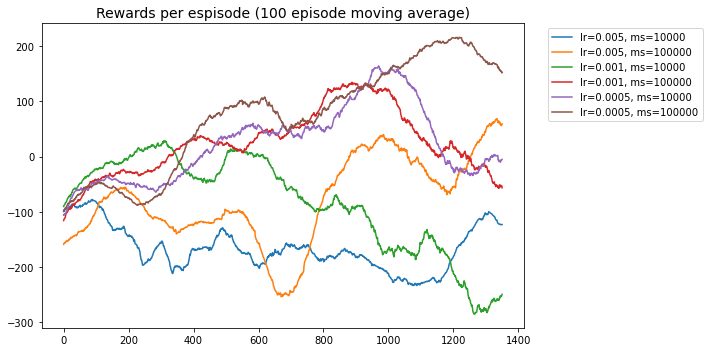

In [33]:
# plot all data 
plt.figure(figsize=(10,5))
for data in data_list:
    i, lr, ms, rewards_history = data
    avg_rewards_history = np.convolve(rewards_history[i-1], np.ones((150,))/150, mode='valid')
    plt.plot(avg_rewards_history, label='lr={}, ms={}'.format(lr, ms))
plt.title('Rewards per espisode (100 episode moving average)', fontsize=14)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.tight_layout()
plt.show()

